In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
from sklearn.preprocessing import QuantileTransformer
import os
import warnings
warnings.filterwarnings("ignore")
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mticker
import seaborn as sns


In [2]:
root_path = '/scratch/users/pburdeau/data/gas_composition'

In [3]:
usgs_data = pd.read_csv(os.path.join(root_path, 'usgs/usgs_processed_with_nanapis.csv'))  # all basins

In [4]:
basins_to_keep = ['Appalachian Basin',
              'Appalachian Basin (Eastern Overthrust Area)',
              'Permian Basin',
              'Arkla Basin',
              'Anadarko Basin',
              'San Joaquin Basin',
              'Denver Basin',
              'Uinta Basin',
              'Green River Basin',
              'Arkoma Basin',
            'Gulf Coast Basin (LA, TX)',
              'Williston Basin',
               'East Texas Basin']
usgs_gdf_main_basins = usgs_data[usgs_data.BASIN_NAME.isin(basins_to_keep)].reset_index(drop=True)

In [ ]:
def find_rmse(empVgm, stAni):
    # Filter data where spacelag is 0 and fit a linear model
    lm_data = empVgm[empVgm['spacelag'] <= 5000]
    if len(lm_data) > 10:
        lm_formula = 'gamma ~ timelag'
        lm_model = ols(lm_formula, data=lm_data).fit()

        filtered_data = empVgm[empVgm['timelag'] <= 365]
        dist_adjusted = filtered_data['spacelag'] / stAni
        predicted_gamma = lm_model.predict(exog=dict(timelag=dist_adjusted))
        rmse = np.sqrt(np.mean((predicted_gamma - filtered_data['gamma'])**2))

        return rmse
    else:
        return np.nan

def compute_diffs_time_space_basin(basin, comp, alpha):
    usgs_basin_gdf = usgs_gdf_main_basins[usgs_gdf_main_basins.BASIN_NAME == basin]
    usgs_basin_gdf = usgs_basin_gdf[~pd.isna(usgs_basin_gdf[comp])]
    
    # Convert geometry to a list of tuples
    points = list(zip(usgs_basin_gdf['X'], usgs_basin_gdf['Y']))
    values = usgs_basin_gdf[comp].astype(float).to_numpy().reshape(-1,1)
    
    if len(values) > 10:
        nst_trans = QuantileTransformer(n_quantiles=500, output_distribution='normal').fit(values)
        values_trans = nst_trans.transform(values)

        values = values_trans.reshape(-1)
        del values_trans

        epochs = usgs_basin_gdf['T'].to_numpy()
        years = usgs_basin_gdf['Year'].to_numpy()
        num_points = len(points)

        distances_space = pdist(points)

        distances_space = squareform(distances_space)

        # Calculate temporal distances
        alpha_squared = alpha ** 2
        distances_time = np.abs(epochs[:, None] - epochs[None, :])

        # Calculate spatiotemporal distances
        distances = np.sqrt(distances_space**2 + (alpha_squared * distances_time**2))

        # Calculate differences in values
        diffs = np.abs(values[:, None] - values[None, :]) ** 2

        # Flatten matrices
        mask_upper_triangle = np.triu(np.ones(num_points, dtype=bool), k=1)
        diffs = diffs[mask_upper_triangle]
        distances = distances[mask_upper_triangle]
        distances_time = distances_time[mask_upper_triangle]
        distances_space = distances_space[mask_upper_triangle]

        return diffs, distances, distances_time, distances_space
    else:
        return [0], [0], [0], [0]

def compute_variances_and_bins(diffs, distances_time, distances_space, alphas, n_bins=6):
    
    variances_by_alpha = {}

    for alpha in alphas:
        if alpha < 1:
            time_bins = np.linspace(np.min(distances_time) * alpha/(4.), np.max(distances_time) * alpha/(4.), n_bins)
            space_bins = np.linspace(np.min(distances_space)/(4.), np.max(distances_space)/(4.), n_bins) # 1m is 5 epochs
        else:
            time_bins = np.linspace(np.min(distances_time)/(4.), np.max(distances_time) /(4.), n_bins)
            scaled_space_bins = time_bins
            space_bins = np.linspace(np.min(distances_space)/(4. * alpha), np.max(distances_space)/(4. * alpha), n_bins) # 1m is 5 epochs
        adjusted_time_distances = distances_time * alpha
        adjusted_space_distances = distances_space * alpha

        time_indices = np.digitize(distances_time, time_bins) - 1
        space_indices = np.digitize(np.array(distances_space) / alpha, scaled_space_bins) - 1

        variances = np.zeros((len(time_bins)-1, len(space_bins)-1, 3))  # 3 for original, time adjusted, space adjusted
        
        for i in range(len(time_bins)-1):
            for j in range(len(space_bins)-1):
                mask_original = (time_indices == i) & (space_indices == j)
                
                if np.any(mask_original):
                    variances[i, j, 0] = np.mean(diffs[mask_original])

        variances_by_alpha[alpha] = variances

    return time_bins, scaled_space_bins, variances_by_alpha

def compute_variances_and_bins_for_est(diffs, distances_time, distances_space, alphas, n_bins=6):
    
    variances_by_alpha = {}

    for alpha in alphas:
        if alpha < 1:
            time_bins = np.linspace(np.min(distances_time) * alpha/(4.), np.max(distances_time) * alpha/(4.), n_bins)
            space_bins = np.linspace(np.min(distances_space)/(4.), np.max(distances_space)/(4.), n_bins) # 1m is 5 epochs
        else:
            time_bins = np.linspace(np.min(distances_time)/(4.), np.max(distances_time) /(4.), n_bins)
            space_bins = np.linspace(np.min(distances_space)/(4. * alpha), np.max(distances_space)/(4. * alpha), n_bins) # 1m is 5 epochs
        adjusted_time_distances = distances_time * alpha
        adjusted_space_distances = distances_space * alpha

        time_indices = np.digitize(distances_time, time_bins) - 1
        space_indices = np.digitize(distances_space, space_bins) - 1

        variances = np.zeros((len(time_bins)-1, len(space_bins)-1, 3))  # 3 for original, time adjusted, space adjusted
        
        for i in range(len(time_bins)-1):
            for j in range(len(space_bins)-1):
                mask_original = (time_indices == i) & (space_indices == j)
                
                if np.any(mask_original):
                    variances[i, j, 0] = np.mean(diffs[mask_original])

        variances_by_alpha[alpha] = variances

    return time_bins, space_bins, variances_by_alpha

def create_dataframe_from_variances(variances_by_alpha, space_bins, time_bins, alphas):
    """
    Create a DataFrame from semivariance calculations.
    
    Parameters:
    - variances_by_alpha: dict, semivariances for each alpha indexed by space and time bins
    - space_bins: array-like, edges of space bins
    - time_bins: array-like, edges of time bins
    - alphas: list, alpha values used in the semivariance calculation
    
    Returns:
    - DataFrame with columns ['alpha', 'space_bin', 'time_bin', 'gamma']
    """
     # Pre-calculate bin centers for more accurate representation
    space_bin_centers = (space_bins[:-1] + space_bins[1:]) / 2
    time_bin_centers = (time_bins[:-1] + time_bins[1:]) / 2
    
    # Prepare data collection
    records = []

    for i, time_center in enumerate(time_bin_centers):
        for j, space_center in enumerate(space_bin_centers):
            gamma_value = variances_by_alpha[i, j]
            # Append each combination of alpha, space, time, and gamma to records
            records.append({
                'spacelag': space_center,
                'timelag': time_center,
                'gamma': gamma_value
            })
    
    # Create DataFrame from records
    df = pd.DataFrame(records)
    return df

In [ ]:
# def estiStAni_lin_space(empVgm, interval):
#     # Filter data where spacelag is 0 and fit a linear model
#     lm_data = empVgm[empVgm['spacelag'] <= 5000]
#     if len(lm_data) > 10:
#         lm_formula = 'gamma ~ timelag'
#         lm_model = ols(lm_formula, data=lm_data).fit()


#         # Optimization function to calculate RMSE
#         def optFun(stAni, empVgm, plot=False):
#             filtered_data = empVgm[empVgm['timelag'] <= 365]
#             dist_adjusted = filtered_data['spacelag'] / stAni
#             predicted_gamma = lm_model.predict(exog=dict(timelag=dist_adjusted))
#             rmse = np.sqrt(np.mean((predicted_gamma - filtered_data['gamma'])**2))

#             if plot:
#                 plt.rcParams.update({'font.size': 14})  # You can adjust the size based on your slide requirements

#                 plt.figure(figsize=(10, 6))

#                 # Plotting empirical variogram
#                 plt.scatter(dist_adjusted, filtered_data['gamma'], label='Empirical Variogram', color='blue', s=50)  # Increase marker size with s=50

#                 # Plotting predicted variogram
#                 plt.scatter(dist_adjusted, predicted_gamma, label='Predicted Variogram', color='red', alpha=0.5, s=50)  # Increase marker size with s=50

#                 # Adding title and labels with updated text
#                 plt.title(f"Predicted vs Empirical Variogram at stAni: {stAni}, RMSE: {rmse}")
#                 plt.xlabel('Adjusted Distance')
#                 plt.ylabel('Variogram')

#                 # Display the legend
#                 plt.legend()

#                 # Show the plot
#                 plt.show()
#             return rmse

#         iteration_count = [0]  # Use a list to have a mutable counter

#         def optFunWrapper(stAni, *args):
#             rmse = optFun(stAni, *args)  # Call the original optimization function
#             print(f"Current stAni: {stAni}, Current RMSE: {rmse}")

#             # Plot every N iterations to manage output volume
#             if iteration_count[0] % 10 == 0:  # Adjust N as needed
#                 optFun(stAni, *args, plot=True)
#             iteration_count[0] += 1

#             return rmse

#         # Define a callback function for additional iterative insights if necessary
#         def print_iter(x, *args):
#             print("Iteration with stAni:", x)

#         # Adjust the minimize call to use the wrapper function and include the callback
#         result = minimize(
#             fun=optFunWrapper,
#             x0=[np.mean(interval)],  # Ensure x0 is an array-like structure for bounds to work correctly
#             args=(empVgm,),
#             method='Nelder-Mead',
#             callback=print_iter,
#             options={'xatol': 1e-1, 'fatol': 1e-10}  # Adjust these values as needed
#         )    

#         # Plot one last time at the end to show the final fit
#         optFun(result.x, empVgm, plot=True)

#         return result.x[0]
#     else:
#         return np.nan

In [ ]:
def estiStAni_lin_space(empVgm, interval, figures_path, colormap):
    # Ensure the output directory exists
    import os
    os.makedirs(figures_path, exist_ok=True)

    # Filter data where spacelag is 0 and fit a linear model
    lm_data = empVgm[empVgm['spacelag'] <= 5000]
    if len(lm_data) > 10:
        lm_formula = 'gamma ~ timelag'
        lm_model = ols(lm_formula, data=lm_data).fit()

        def optFun(stAni, empVgm, plot=False, label=None, colormap=None):
            filtered_data = empVgm[empVgm['timelag'] <= 365]
            dist_adjusted = filtered_data['spacelag'] / stAni
            predicted_gamma = lm_model.predict(exog=dict(timelag=dist_adjusted))
            rmse = np.sqrt(np.mean((predicted_gamma - filtered_data['gamma'])**2))

            if plot:
                stAni_scalar = stAni[0] if isinstance(stAni, (np.ndarray, list)) else stAni  # Extract scalar if needed
                fig, ax1 = plt.subplots(figsize=(11, 8))
                plt.rcParams.update({'font.size': 26})

                # Create fixed colors from the colormap
                cmap = colormap or sns.cubehelix_palette(start=2.1, hue=1.7, light=0.9, dark=0.2, rot=0.4, as_cmap=True, reverse=True)
                colors = [cmap(0.2), cmap(0.5)]  # Two fixed tones from the colormap
                # Plot empirical variogram on the primary x-axis (spatial distances in meters)
                scatter1 = ax1.scatter(
                    filtered_data['spacelag'] / 1000,
                    filtered_data['gamma'],
                    label=r"Empirical spatial variogram ($\gamma_s$)",
                    color=colors[0],
                    s=50
                )
                ax1.set_xlabel(r"Spatial distance ($D_s$) [km]")
                ax1.set_ylabel("Semivariance [mol %$^2$]")

                # Plot predicted variogram aligned to temporal distances
                scatter2 = ax1.scatter(
                    filtered_data['spacelag'] / 1000,
                    predicted_gamma,
                    label=r"$\beta_0 + \beta_1 \cdot \frac{D_s}{\alpha}$",
                    color=colors[1],
                    alpha=0.6,
                    s=50
                )
                
                ax1.set_title(f"$\\alpha = {stAni_scalar:.1f}$, RMSE: {rmse:.1f} mol %$^2$\n")
                legend = ax1.legend(loc="upper left", fontsize=26)
                legend.get_frame().set_alpha(0.5)  # Set transparency to 50%

                # Save the plot
                if label:
                    filename = f"plot_stAni_{label}.eps"
                else:
                    filename = f"plot_stAni_{stAni_scalar:.2f}.eps"

                plt.tight_layout()
                plt.savefig(os.path.join(figures_path, filename), format='eps', dpi=300)
                plt.show()
                plt.close(fig)

            return rmse



        # Wrapper function for optimization
        iteration_count = [0]

        def optFunWrapper(stAni, *args):
            rmse = optFun(stAni, *args)
            if iteration_count[0] % 10 == 0:
                optFun(stAni, *args, plot=True)
            iteration_count[0] += 1
            return rmse

        # Run optimization
        result = minimize(
            fun=optFunWrapper,
            x0=[np.mean(interval)],
            args=(empVgm,),
            method='Nelder-Mead',
            options={'xatol': 1e-1, 'fatol': 1e-10}
        )

        # Plot optimal result
        optFun(result.x[0], empVgm, plot=True, label="optimal")

        # Plot for stAni = 1
        optFun(1, empVgm, plot=True, label="1")

        # Plot for stAni = 40
        optFun(40, empVgm, plot=True, label="40")

        return result.x[0]
    else:
        return np.nan


# To integrate it into your complete function with specific parameters, pass this to the `estiStAni_lin_space` function.
# Please let me know if you need me to connect it explicitly.


alphas = [1]


def plot_3d(alphas, diffs, distances_time, distances_space, nbins=6):
    alpha = alphas[0]
    time_bins, space_bins, variances_by_alpha = compute_variances_and_bins(diffs, distances_time, distances_space, alphas)
    space_bins_sorted = np.sort(space_bins)
    time_bins_sorted = np.sort(time_bins)

    space_centers = (space_bins_sorted[:-1] + space_bins_sorted[1:]) / 2
    time_centers = (time_bins_sorted[:-1] + time_bins_sorted[1:]) / 2

    X, Y = np.meshgrid(space_centers, time_centers)
    Z = variances_by_alpha[alpha][..., 0] 

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_ylabel('Time')
    ax.set_xlabel('Space')
    ax.set_zlabel('Variance')
    ax.invert_xaxis()
    fig.colorbar(surf, shrink=0.5, aspect=5)
    
    ax.view_init(elev=20, azim=-45)  # You can adjust these angles to get the desired viewpoint

    plt.show()
    
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    contour = ax.contourf(X, Y, Z, 50, cmap='viridis', extend3d=True)
    ax.set_ylabel('Time')
    ax.set_xlabel('Space')
    ax.set_zlabel('Variance')
    ax.invert_xaxis()
    fig.colorbar(surf, shrink=0.5, aspect=5)
    
    ax.view_init(elev=20, azim=-45)  # You can adjust these angles to get the desired viewpoint

    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


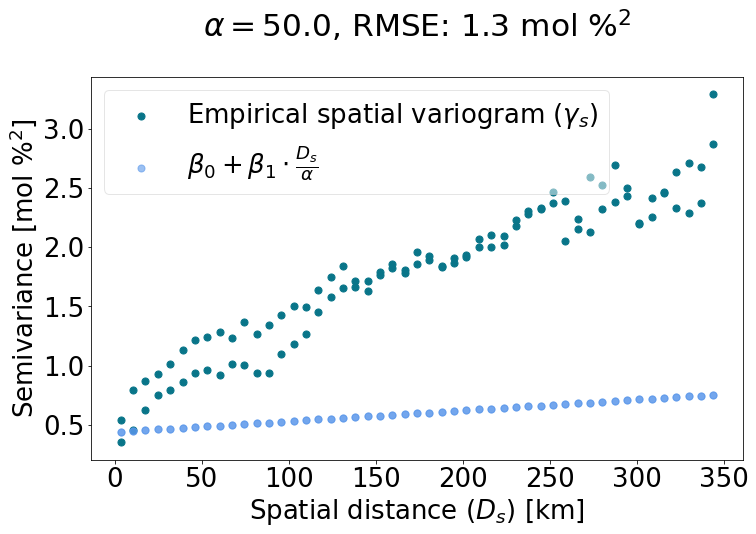

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


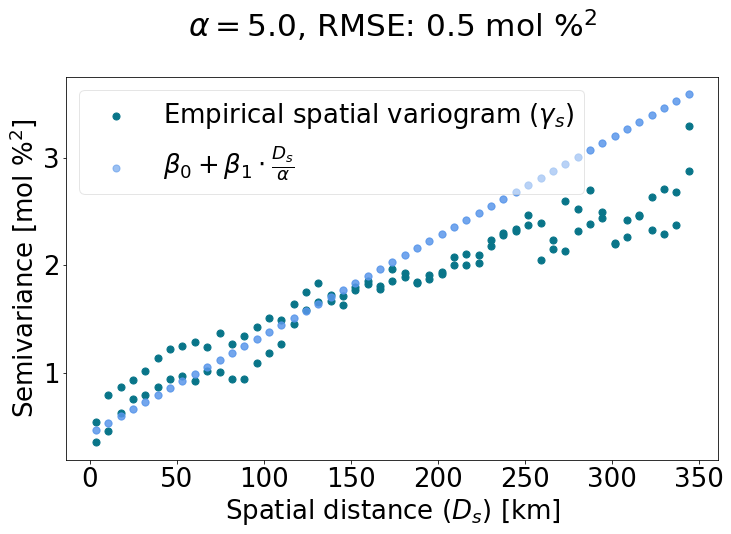

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


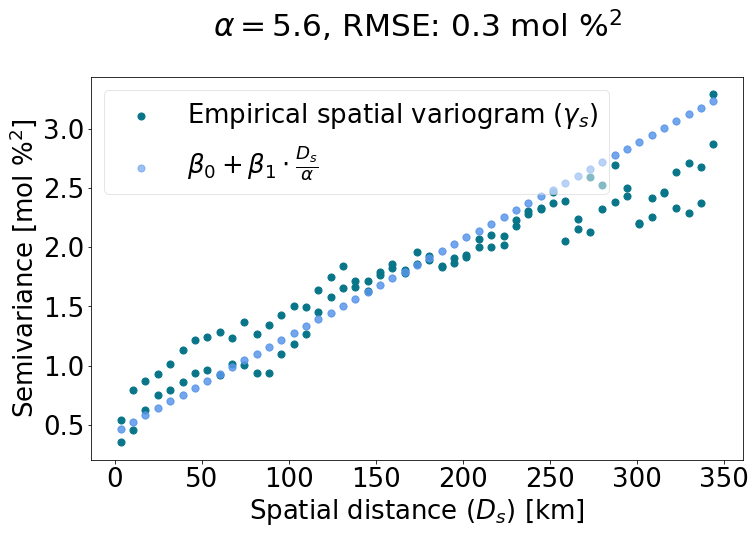

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


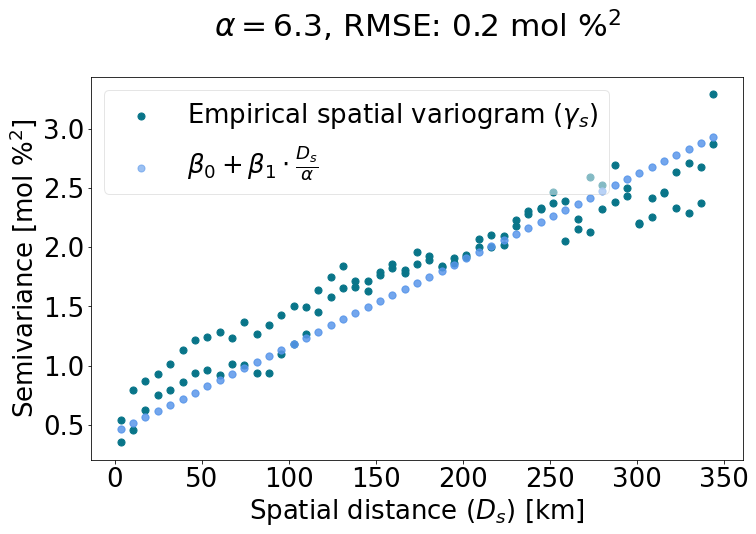

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


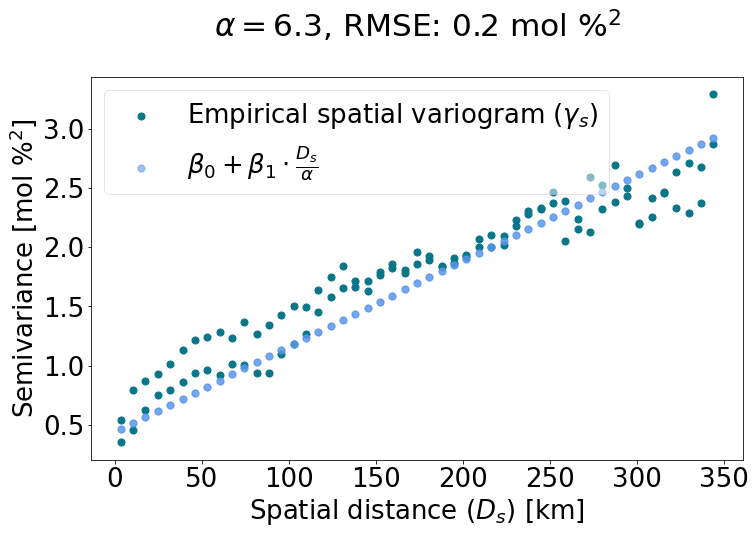

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


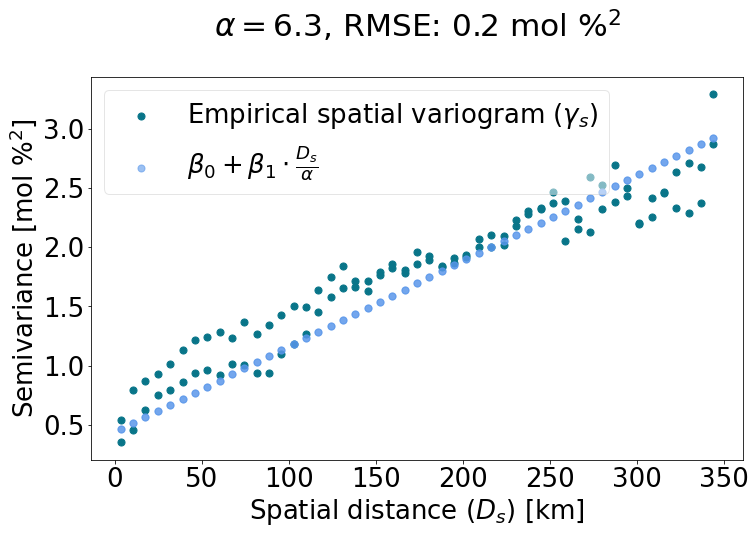

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


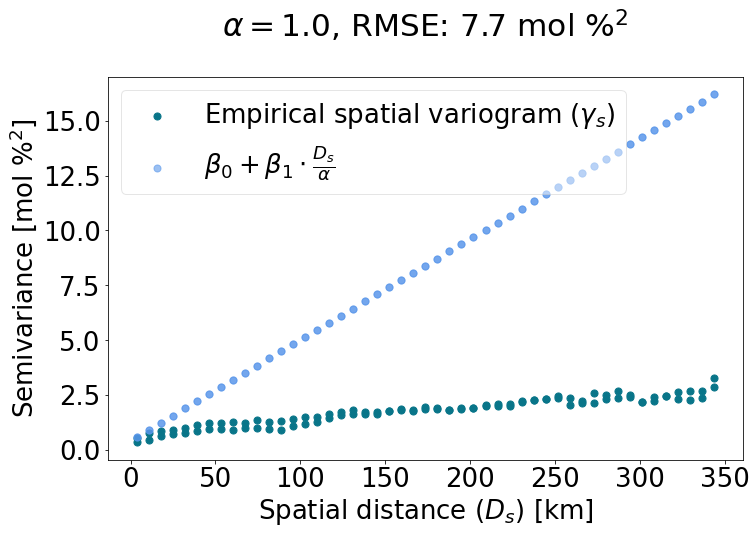

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


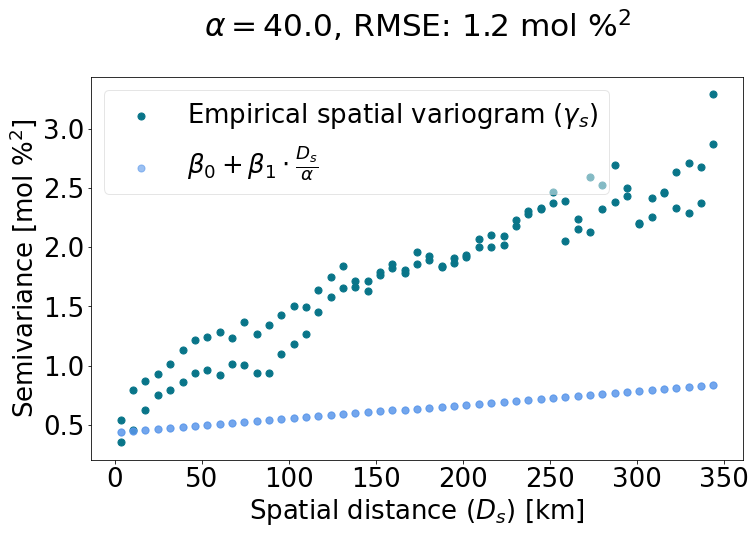

6.340791854858242

In [136]:
estiStAni_lin_space(df_variances, interval, figures_path='figures_out', colormap=sns.cubehelix_palette(start=2.1, hue=1.7, light=0.9, dark=0.2, rot=0.4, as_cmap=True, reverse=True)
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


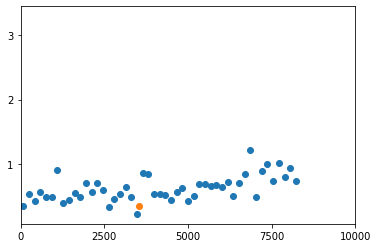

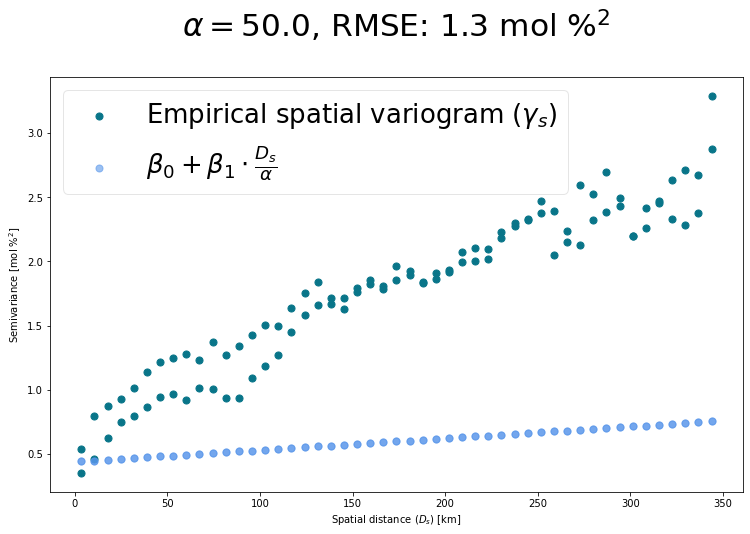

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


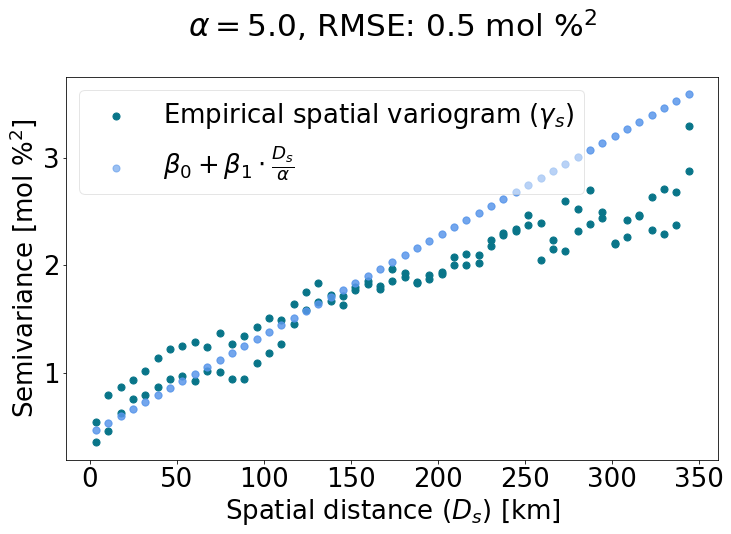

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


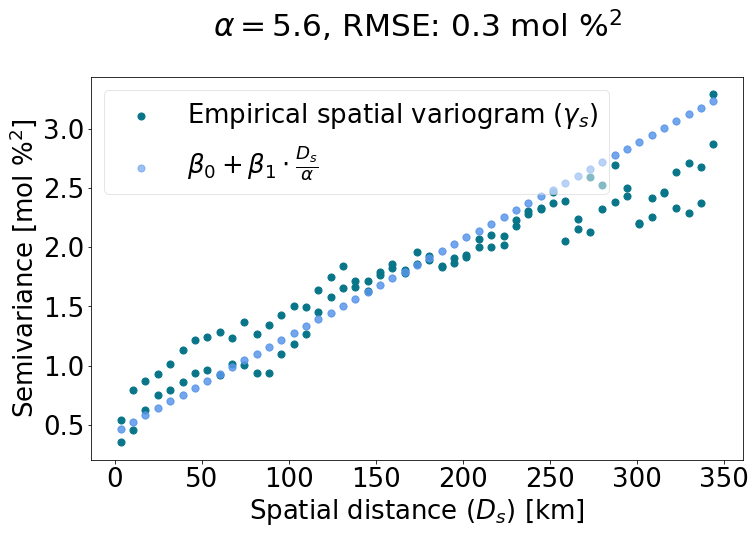

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


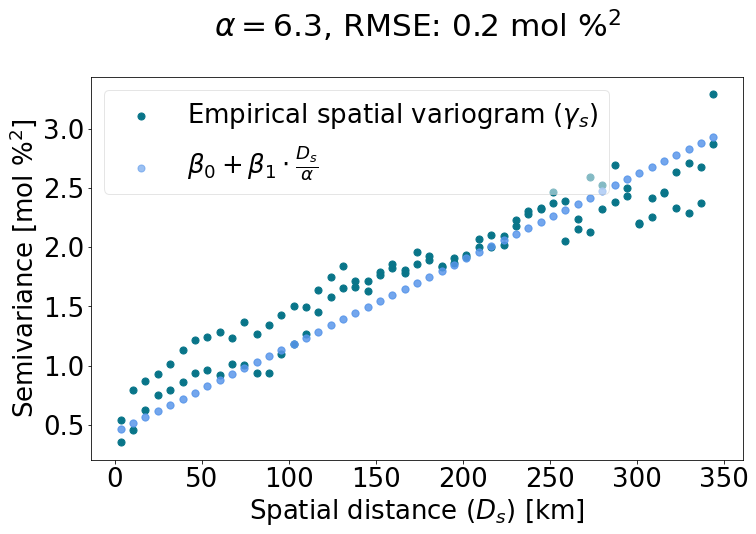

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


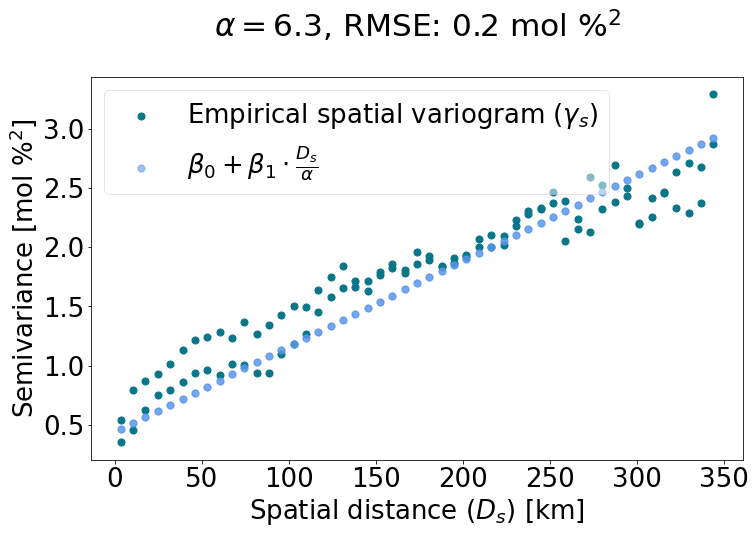

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


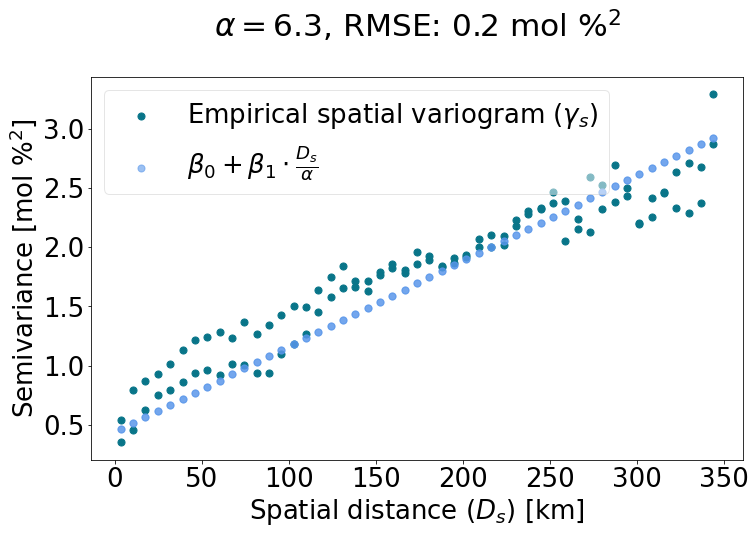

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


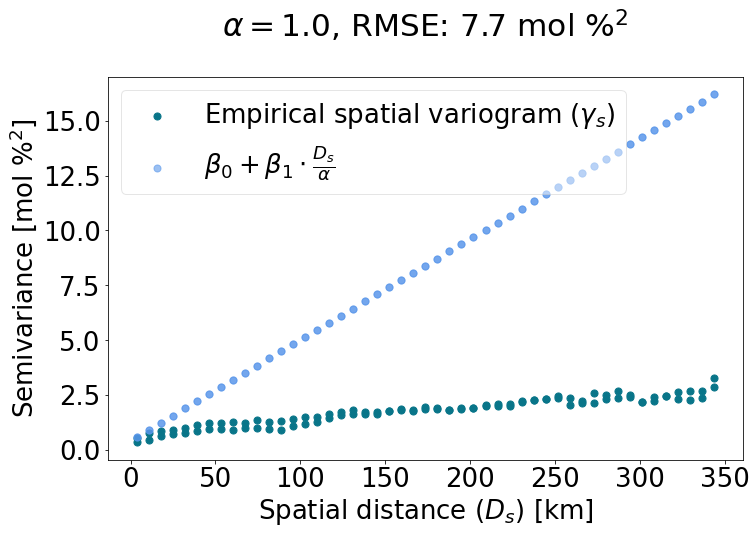

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


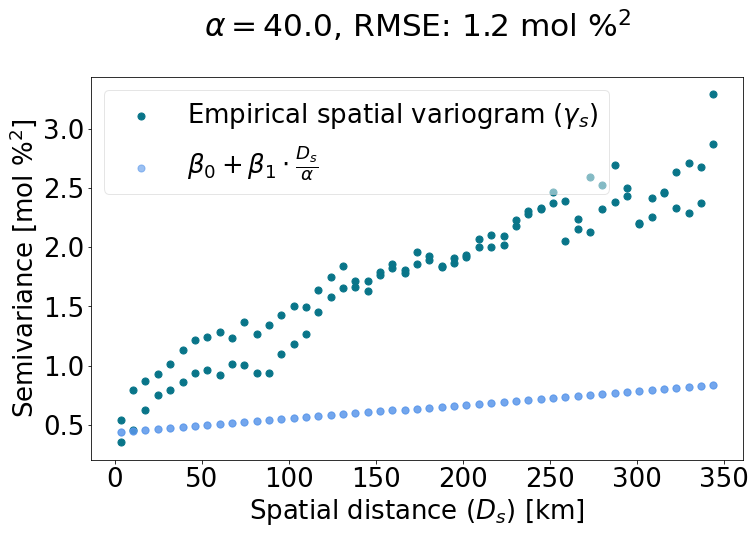

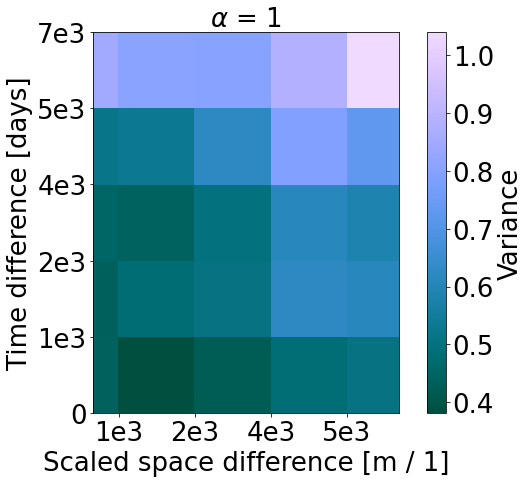

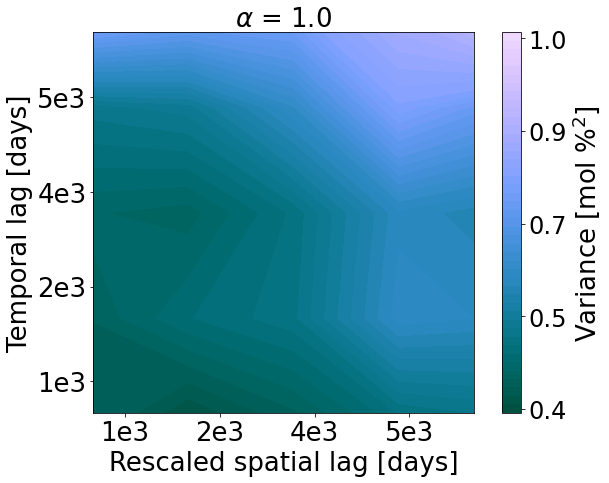

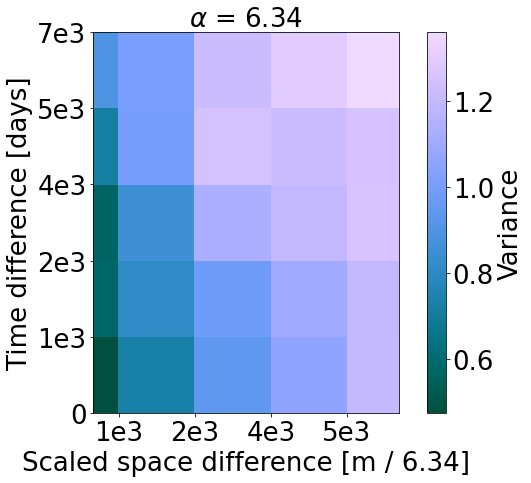

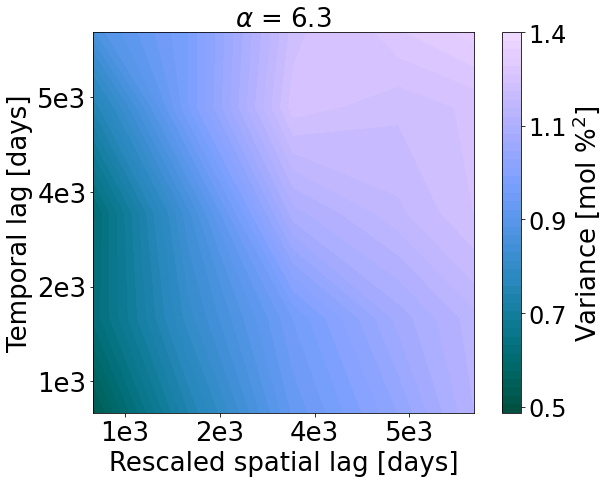

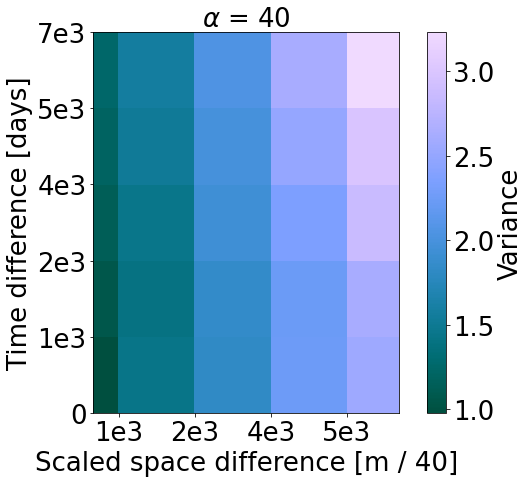

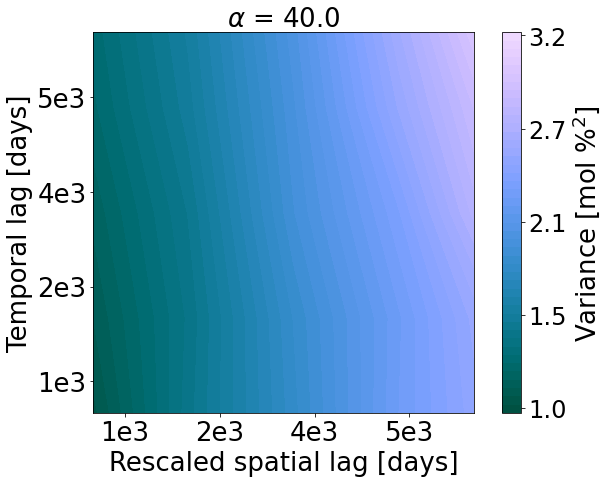

In [9]:
basin = 'Permian Basin'
comp = 'C1'
alpha = 1

# create array of all diffs within basins

all_diffs = []
all_distances_time = []
all_distances_space = []
all_distances = []
for basin in basins_to_keep:
    diffs, distances, distances_time, distances_space = compute_diffs_time_space_basin(basin, comp, alpha)
    all_diffs = np.concatenate([all_diffs, diffs])
    all_distances_time = np.concatenate([all_distances_time, distances_time])
    all_distances_space = np.concatenate([all_distances_space, distances_space])
    all_distances = np.concatenate([all_distances, distances])


res = []
    
alphas = [1]
time_bins, space_bins, variances_by_alpha = compute_variances_and_bins_for_est(all_diffs, all_distances_time, all_distances_space, alphas, 50)

df_variances = create_dataframe_from_variances(variances_by_alpha[alphas[0]][..., 0], space_bins, time_bins, alphas)

plt.scatter(df_variances[df_variances.spacelag <= 5000].timelag, df_variances[df_variances.spacelag <= 5000].gamma)
plt.xlim(0,10000)

plt.scatter(df_variances[df_variances.timelag <= 200].spacelag, df_variances[df_variances.timelag <= 200].gamma)
interval = [0.1,100]

res.append(estiStAni_lin_space(df_variances, interval, figures_path='figures_out', colormap=sns.cubehelix_palette(start=2.1, hue=1.7, light=0.9, dark=0.2, rot=0.4, as_cmap=True, reverse=True)
))
stAnis = np.linspace(1, 50, 100)

nbins = 6
plot_2d([1], all_diffs, all_distances_time, all_distances_space, nbins, cubehelix_custom)

nbins = 6
plot_2d([6.34], all_diffs, all_distances_time, all_distances_space, nbins, cubehelix_custom)

nbins = 6
plot_2d([40], all_diffs, all_distances_time, all_distances_space, nbins, cubehelix_custom)

In [64]:
def plot_2d(alphas, diffs, distances_time, distances_space, nbins=6, cubehelix_custom=sns.cubehelix_palette(start=0.2, hue=1.4, light=0.8, dark=0.3, as_cmap=True, reverse=True)):
    vmin, vmax = 0, 3  # Fixed colorbar range
    fontsize = 26
    alpha = alphas[0]
    time_bins, space_bins, variances_by_alpha = compute_variances_and_bins(diffs, distances_time, distances_space, alphas, nbins)
    space_bins_sorted = np.sort(space_bins)
    time_bins_sorted = np.sort(time_bins)

    space_centers = (space_bins_sorted[:-1] + space_bins_sorted[1:]) / 2
    time_centers = (time_bins_sorted[:-1] + time_bins_sorted[1:]) / 2

    X, Y = np.meshgrid(space_centers, time_centers)
    Z = variances_by_alpha[alpha][..., 0]

    # Set common limits
    common_limit = max(space_centers[-1], time_centers[-1])
    common_ticks = np.linspace(0, common_limit, 6)  # 6 evenly spaced ticks

    # Plot heatmap
    fig, ax = plt.subplots(figsize=(10, 7))
    heatmap = ax.imshow(Z, cmap=cubehelix_custom, aspect='auto', origin='lower',
                        extent=[0, common_limit, 0, common_limit])
    ax.set_ylabel('Time difference [days]', fontsize=fontsize)
    ax.set_xlabel(f'Scaled space difference [m / {alpha}]', fontsize=fontsize)
    ax.set_title(rf'$\alpha$ = {alpha}', fontsize=fontsize)
    fig.colorbar(heatmap, ax=ax, label='Variance')

    # Synchronize ticks
    ax.set_xticks(common_ticks)
    ax.set_yticks(common_ticks)

    # Apply scientific notation formatter
    def format_ticks(value, _):
        if value == 0:
            return "0"
        power = int(np.floor(np.log10(abs(value))))
        factor = int(value / (10**power))
        return f"{factor}e{power}"

    ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_ticks))
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(format_ticks))
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.set_aspect('equal', 'box')
    ax.set_xlim(1000, 7000)
    plt.savefig(f'figures_out/heatmap_alpha_{alpha:.1f}.eps', format='eps', dpi=300)
    plt.show()

    # Plot contour map
    fig, ax = plt.subplots(figsize=(10, 7))
    # Filled contours
    contour = ax.contourf(X, Y, Z, levels=np.linspace(vmin, vmax, 25), cmap=cubehelix_custom, vmin=vmin, vmax=vmax)

    # Add contour lines on top
    lines = ax.contour(X, Y, Z, levels=np.linspace(vmin, vmax, 5), colors='black', linewidths=0.5)
    ax.clabel(lines, inline=True, fontsize=fontsize - 6, fmt="%.1f")  # Optional: label lines

    ax.set_ylabel('Temporal lag [days]', fontsize=fontsize)
    ax.set_xlabel(rf'Rescaled spatial lag [days]', fontsize=fontsize)
    ax.set_title(rf'$\alpha$ = {alpha:.1f}', fontsize=fontsize)



    # Synchronize ticks for contour map
    ax.set_xticks(common_ticks)
    ax.set_yticks(common_ticks)

    ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_ticks))
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(format_ticks))
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.set_xlim(1000, 7000)
    ax.set_ylim(1000, 7000)
    


    cbar = fig.colorbar(contour, ax=ax)
    cbar.set_label(r'Variance [mol %$^2$]', fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize - 2)
#     cbar.set_ticks(np.linspace(vmin, vmax, 5))
#     cbar.ax.set_yticklabels([f'{tick:.1f}' for tick in np.linspace(vmin, vmax, 5)])


    num_ticks = 5  # Set the desired number of ticks
    tick_values = np.linspace(vmin, vmax, num_ticks)  # Generate evenly spaced ticks
    cbar.set_ticks(tick_values)  # Set the custom ticks
    cbar.ax.set_yticklabels([f'{tick:.1f}' for tick in tick_values])
    ax.set_aspect('equal', 'box')
    plt.savefig(f'figures_out/contourmap_alpha_{alpha:.1f}.eps', format='eps', dpi=300)
    plt.show()


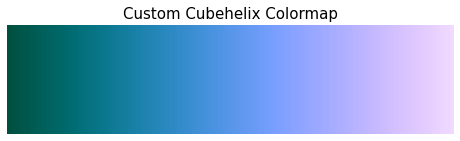

In [65]:
# Create a customized Cubehelix colormap
cubehelix_custom = sns.cubehelix_palette(start=2.1, hue=1.7, light=0.9, dark=0.2, rot=0.4, as_cmap=True, reverse=True)
gradient = np.linspace(0, 1, 256).reshape(1, -1)

# Display the custom Cubehelix colormap
fig, ax = plt.subplots(figsize=(8, 2))
ax.imshow(gradient, aspect='auto', cmap=cubehelix_custom)
ax.set_axis_off()
ax.set_title('Custom Cubehelix Colormap', fontsize=15)
plt.show()

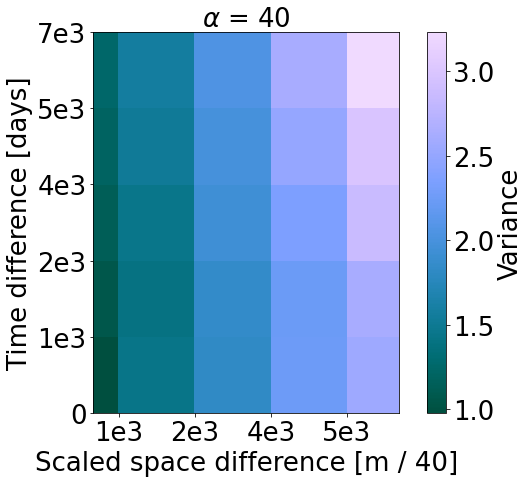

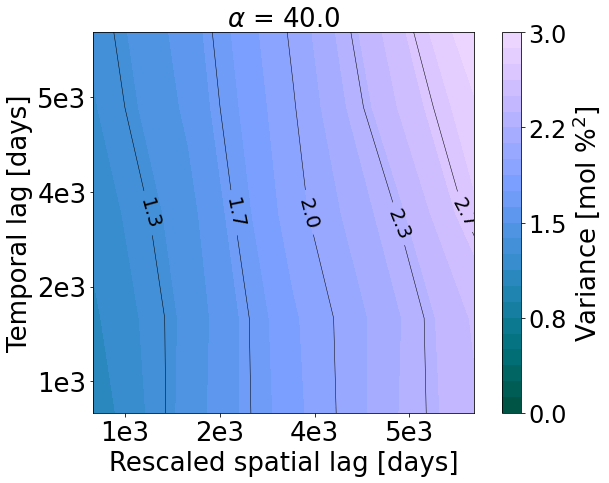

In [66]:
nbins = 6
plot_2d([40], all_diffs, all_distances_time, all_distances_space, nbins, cubehelix_custom)

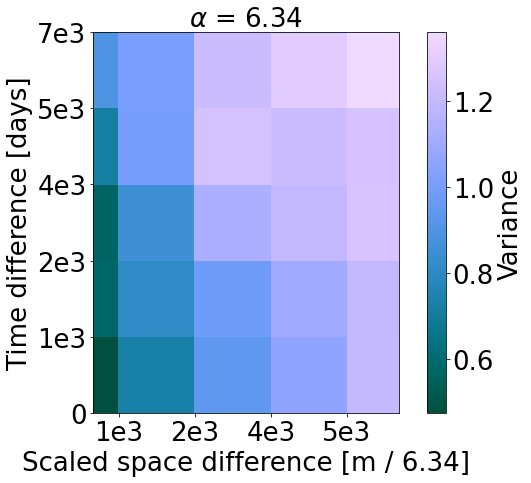

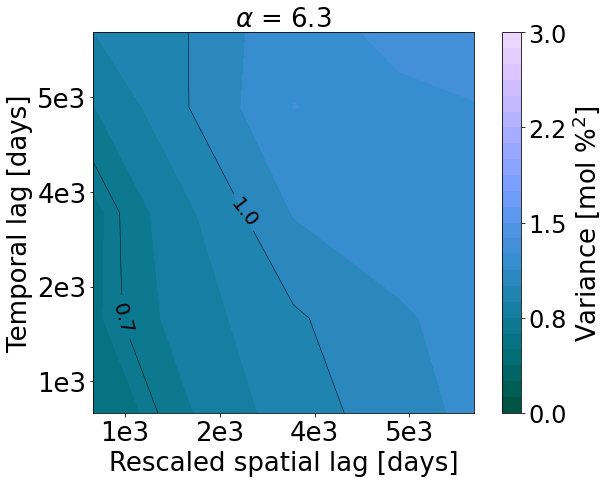

In [67]:
nbins = 6
plot_2d([6.34], all_diffs, all_distances_time, all_distances_space, nbins, cubehelix_custom)

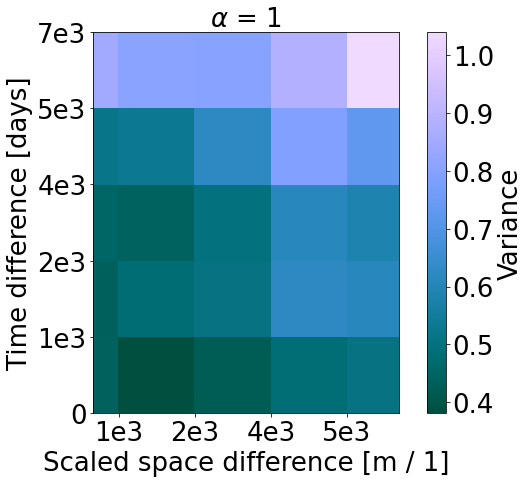

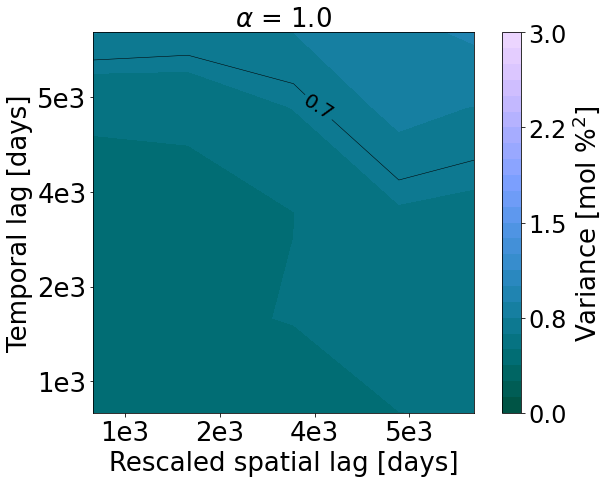

In [68]:
nbins = 6
plot_2d([1], all_diffs, all_distances_time, all_distances_space, nbins, cubehelix_custom)

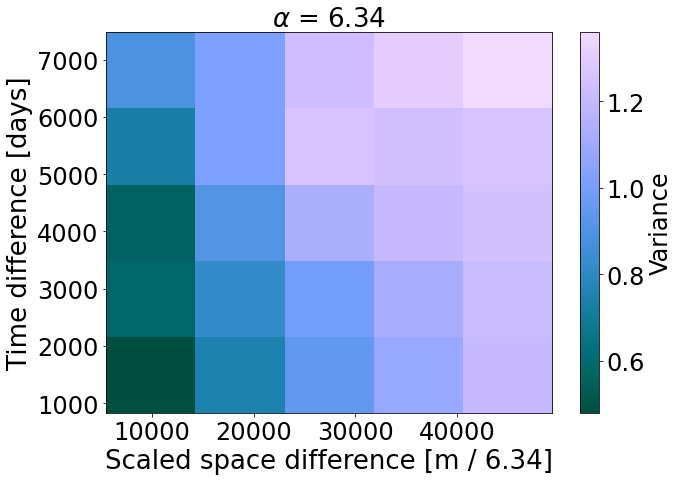

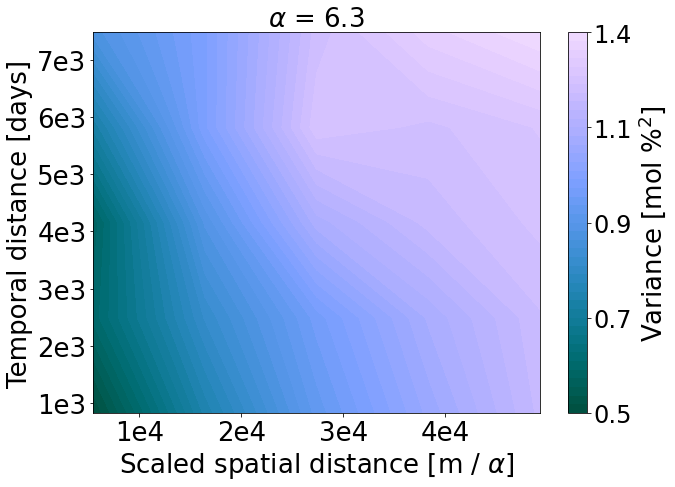

In [82]:
nbins = 6

plot_2d([6.34], all_diffs, all_distances_time, all_distances_space, nbins, cubehelix_custom)

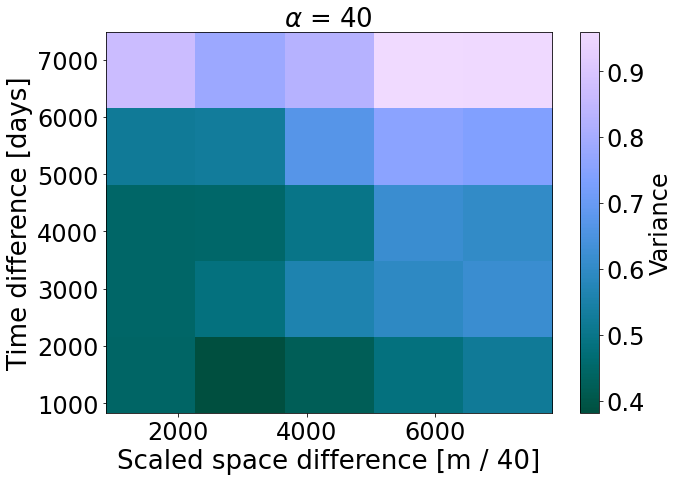

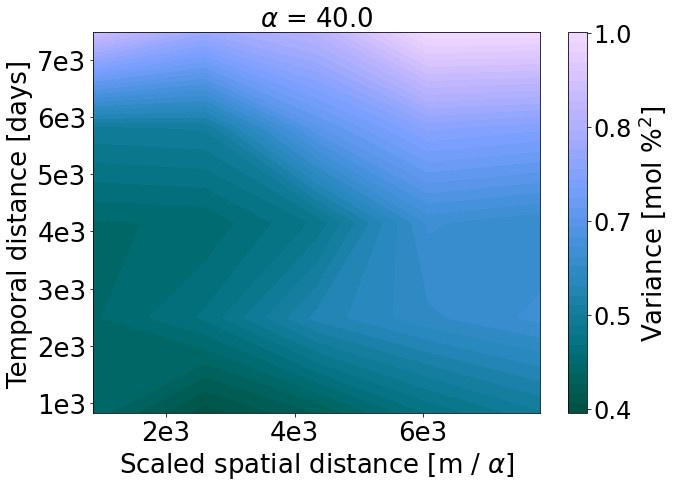

In [83]:
nbins = 6

plot_2d([40], all_diffs, all_distances_time, all_distances_space, nbins, cubehelix_custom)

In [333]:
cmap = sns.cubehelix_palette(start=0, hue=0, light=0.8, dark=0.1, as_cmap=True, reverse=False)

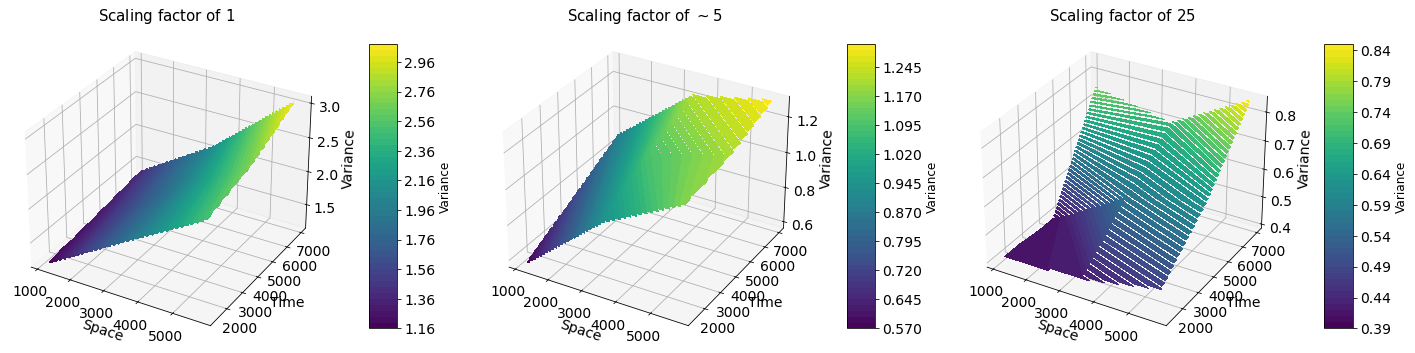

In [79]:
def plot
alphas = [1, 6.6, 50]
time_bins, space_bins, variances_by_alpha = compute_variances_and_bins(all_diffs, all_distances_time, all_distances_space, alphas, n_bins=4)

# Create the grid for space and time (fewer bins)
space_centers = (space_bins[:-1] + space_bins[1:]) / 2
time_centers = (time_bins[:-1] + time_bins[1:]) / 2
X, Y = np.meshgrid(space_centers, time_centers)

# Set up the figure with subplots
fig, ax = plt.subplots(1, figsize=(20, 7), subplot_kw={"projection": "3d"})
titles = [r"Scaling factor of $1$", r"Scaling factor of $\sim$5", r"Scaling factor of $25$"]

# Iterate over alphas and create subplots
Z = variances_by_alpha[alpha][..., 0]  # Variances for the given alpha

# Create the 3D contour plot
contour = ax.contourf(X, Y, Z, 50, cmap='viridis', extend3d=True)

# Set the labels and title
ax.set_xlabel('Space')
ax.set_ylabel('Time')
ax.set_zlabel('Variance')

# Add a colorbar to the right of each plot
cbar = fig.colorbar(contour, ax=ax, shrink=0.6, aspect=10, pad=0.1)
cbar.set_label('Variance', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


1.0555355510583144
0.4802923632754251
0.35576629102576457


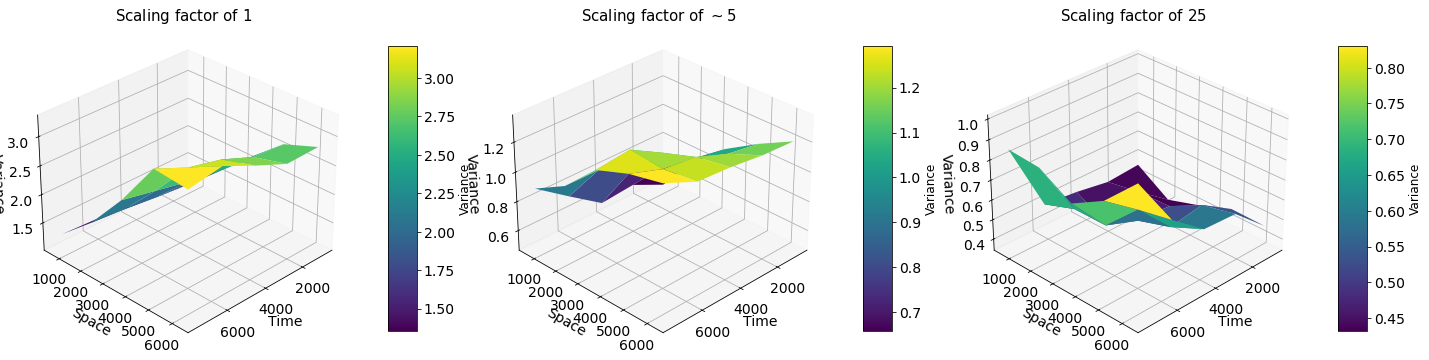

In [107]:
# Assuming compute_variances_and_bins is defined elsewhere
# and variances_by_alpha is calculated from your data:
alphas = [0.8, 6.34, 50]
time_bins, space_bins, variances_by_alpha = compute_variances_and_bins(all_diffs, all_distances_time, all_distances_space, alphas, n_bins=6)

# Create the grid for space and time (fewer bins)
space_centers = (space_bins[:-1] + space_bins[1:]) / 2
time_centers = (time_bins[:-1] + time_bins[1:]) / 2
Y, X = np.meshgrid(space_centers, time_centers)

# Set up the figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 7), subplot_kw={"projection": "3d"})
titles = [r"Scaling factor of $1$", r"Scaling factor of $\sim$5", r"Scaling factor of $25$"]

# Iterate over alphas and create subplots
for i, alpha in enumerate(alphas):
    Z = variances_by_alpha[alpha][..., 0]  # Variances for the given alpha
    ax = axes[i]

    # Use plot_surface instead of contourf
    surface = ax.plot_surface(X, Y, Z, cmap='viridis')
    print(np.min(variances_by_alpha[alpha][..., 0]))
    ax.set_zlim(np.min(variances_by_alpha[alpha][..., 0]), np.max(variances_by_alpha[alpha][..., 0]))
    # Set the labels and title
    ax.set_ylabel('Space')
    ax.set_xlabel('Time')
    ax.set_zlabel('Variance')
    ax.set_title(titles[i], fontsize=15)
    ax.view_init(azim=45)  # Elevation = 30°, Azimuth = 45°

    # Add a colorbar to the right of each plot
    cbar = fig.colorbar(surface, ax=ax, shrink=0.6, aspect=10, pad=0.1)
    cbar.set_label('Variance', fontsize=12)
    
# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Test with fake data

# Test variance bin calculations

In [11]:
data = {
    'spacelag': [100, 200, 300, 5000, 10000, 15000],
    'timelag': [10, 20, 30, 365, 500, 700],
    'gamma': [0.2, 0.4, 0.6, 1.2, 1.8, 2.1]
}

empVgm = pd.DataFrame(data)

data = {
    'geometry': [Point(10, 20), Point(30, 40), Point(50, 60)],
    'C1': [0.1, 0.2, 0.3],  # Assuming 'C1' is the component
    'epochs': [2000, 2005, 2010],
    'Year': [2000, 2005, 2010],
    'BASIN_NAME': ['Permian Basin', 'Permian Basin', 'Permian Basin']  # Add BASIN_NAME
}

usgs_gdf_main_basins = gpd.GeoDataFrame(data, crs="EPSG:4326")

# Call compute_diffs_time_space_basin function
diffs, distances, distances_time, distances_space = compute_diffs_time_space_basin('Permian Basin', 'C1', 1.0)

# Call compute_variances_and_bins function
alphas = [1]
time_bins, space_bins, variances_by_alpha = compute_variances_and_bins(diffs, distances_time, distances_space, alphas)

# Call estiStAni_lin_space function
interval = [0.1, 100]
stAni = estiStAni_lin_space(empVgm, interval)

# For plotting the RMSE:
stAnis = np.linspace(1, 50, 100)
X = stAnis
Y = [find_rmse(empVgm, stAni) for stAni in stAnis]

## Test plots

/var/folders/w4/yrdxcw817vz7csmx310q_gjc0000gn/T/ipykernel_89640/3698803501.py:50: UserWarning: The following kwargs were not used by contour: 'extend3d'
  contour = ax.contourf(X, Y, Z, 50, cmap='viridis', extend3d=True)


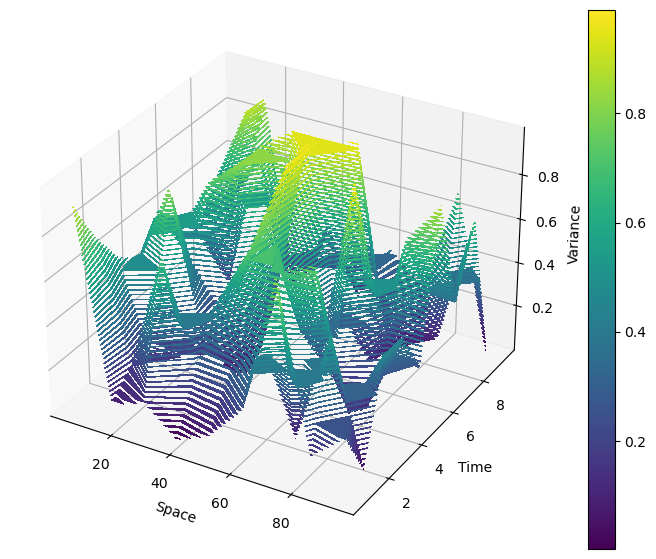

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Fake inputs for diffs and distances
num_points = 100
np.random.seed(0)  # For reproducibility

# Generate random differences (diffs) and spatiotemporal distances
diffs = np.random.rand(num_points)  # Differences in values between points
distances_time = np.random.rand(num_points) * 10  # Random time distances (scaled by a factor)
distances_space = np.random.rand(num_points) * 100  # Random space distances (scaled by a factor)

# Example alphas
alphas = [1]

# Define a simple function for compute_variances_and_bins to simulate variances
def compute_variances_and_bins(diffs, distances_time, distances_space, alphas, n_bins=10):
    variances_by_alpha = {}
    
    # For each alpha, create random variances
    for alpha in alphas:
        # Create random time and space bins
        time_bins = np.linspace(0, np.max(distances_time), n_bins)
        space_bins = np.linspace(0, np.max(distances_space), n_bins)
        
        # Random variance matrix (fake data)
        variances = np.random.rand(n_bins - 1, n_bins - 1, 3)  # 3 for original, time adjusted, space adjusted
        
        variances_by_alpha[alpha] = variances
    
    return time_bins, space_bins, variances_by_alpha

# Call the fake function to get the bins and variances
time_bins, space_bins, variances_by_alpha = compute_variances_and_bins(diffs, distances_time, distances_space, alphas)

# Create the grid for space and time using the bin midpoints
space_centers = (space_bins[:-1] + space_bins[1:]) / 2
time_centers = (time_bins[:-1] + time_bins[1:]) / 2
X, Y = np.meshgrid(space_centers, time_centers)

# Z is your variances_by_alpha for the first alpha value (just using the original variance here)
Z = variances_by_alpha[alphas[0]][..., 0]

# Create a 3D figure
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Create the 3D contour plot using the `contourf` function for filled contour
contour = ax.contourf(X, Y, Z, 50, cmap='viridis', extend3d=True)

# Set the labels
ax.set_xlabel('Space')
ax.set_ylabel('Time')
ax.set_zlabel('Variance')

# Add a color bar
mappable = plt.cm.ScalarMappable(cmap='viridis')
mappable.set_array(Z)
plt.colorbar(mappable)

# Show the plot
plt.show()